** Evaluate runtime performance and number of nuclei detected in a given test sample:**

In [1]:
# show images inline
%matplotlib inline
from collections import defaultdict
# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2
from skimage.color import rgb2hed
# import keras
import keras

# import keras_retinanet
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"


Using TensorFlow backend.


In [2]:
model_path = os.path.join('/home/user/keras-retinanet/snapshots/resnet50_csv_37.h5')

In [3]:
model = keras.models.load_model(model_path, custom_objects=custom_objects)
labels_to_names = {0: 'nucleus'}

/home/user/.local/lib/python3.6/site-packages/keras/models.py:274: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  sample_weight_mode=sample_weight_mode)


In [4]:
import glob
test_imgs = glob.glob('../Image 4 Tiles/*.png')

In [5]:
print('Number of test tiles from sample 4: {}'.format(len(test_imgs)))

Number of test tiles from sample 4: 13746


In [6]:
import tqdm
all_detections = defaultdict(list)
for index_,img in tqdm.tqdm(enumerate(test_imgs)):
    image = read_image_bgr(img)
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    image = preprocess_image(image)
    image, scale = resize_image(image)

    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))

    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    detections[0, :, :4] /= scale
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    # correct for image scale
        if score < 0.50:
            continue
        else:
            b = detections[0, idx, :5].astype(int)
            x = int((b[0]+b[2])/2)
            y = int((b[1]+b[3])/2)
            all_detections[img.split('/')[2]].append([x,y,score])

13746it [28:11,  8.13it/s]


In [7]:
detections[0][0][3]

159.75343

In [8]:
total_count=0
for k, item in all_detections.items():
    total_count += 1

In [9]:
total_count

12993

In [10]:
np.save("test_preds/prediction_dict",all_detections)

In [12]:
import pandas as pd
df = pd.DataFrame([],columns=list('ABCD'))


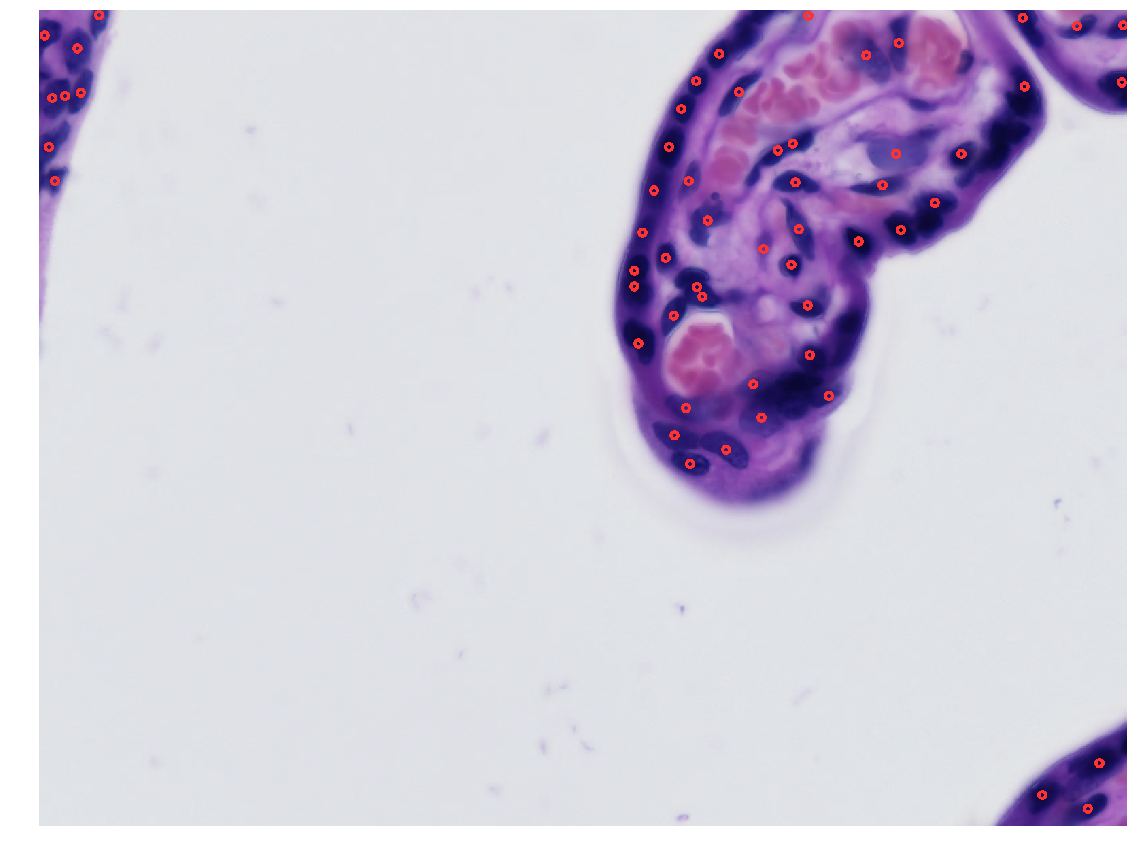

In [13]:
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.50:
        continue
    b = detections[0, idx, :4].astype(int)
    x = int((b[0]+b[2])/2)
    y = int((b[1]+b[3])/2)
    cv2.circle(draw, (x,y),5,(255, 50, 50), 3)
    caption = "{} {:.3f}".format(labels_to_names[label], score)
plt.figure(figsize=(25, 15))
plt.axis('off')
plt.imshow(draw)

In [14]:
a = [[(k, *y) for y in v] for k,v in all_detections.items()]
a = [item for sublist in a for item in sublist]

In [15]:
df = pd.DataFrame(a, columns=['filename','x','y','probability'])


In [16]:
pd.to_pickle(df,'test_preds/all_image4_predictions')

In [17]:
print('Number of nuclei detected: {}'.format(len(df)))

Number of nuclei detected: 1299435


In [18]:
df.head()

,filename,x,y,probability
0,4_m00856_ORG.png,1045,1044,0.980184
1,4_m00856_ORG.png,1287,408,0.979314
2,4_m00856_ORG.png,1230,909,0.975314
3,4_m00856_ORG.png,99,213,0.973230
4,4_m00856_ORG.png,1266,874,0.968433
